In [ ]:
# Phrase 3 : RFM Analysis & Customer Segmentation
# Goal: Calculate Recency, Frequency, Monetary → Score customers → Create segments

# 1. Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import drive

In [ ]:
# Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the CLEANED data
file_path = "/content/drive/MyDrive/Custora-RFM-Based Customer Segmentation & Retention Analysis/clean_online_retail.csv"
df = pd.read_csv(file_path, parse_dates=['InvoiceDate'])

In [ ]:
# Quick check
print("Shape:", df.shape)
print("Date range:", df['InvoiceDate'].min(), "to", df['InvoiceDate'].max())
print("Unique customers:", df['CustomerID'].nunique())

Shape: (397884, 8)
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Unique customers: 4338


In [ ]:
# Create TotalPrice (if not already there)
if 'TotalPrice' not in df.columns:
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [ ]:
# Step A: Calculate RFM values per custome
# Snapshot date = one day after the last purchase in dataset
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Snapshot date for recency:", snapshot_date)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,          # Recency: days since last purchase
    'InvoiceNo':   'nunique',                                         # Frequency: number of distinct invoices
    'TotalPrice':  'sum'                                              # Monetary: total spend
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("\nRFM table head:")
print(rfm.head())

print("\nRFM descriptive stats:")
print(rfm.describe())

Snapshot date for recency: 2011-12-10 12:50:00

RFM table head:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40

RFM descriptive stats:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000


In [ ]:
# Step B: Assign RFM Scores (1 to 5 scale)
# Higher score = better (except Recency: lower days = better)
# Manual binning that works well for Online Retail dataset

# Recency: lower is better
rfm['R_Score'] = pd.cut(rfm['Recency'],
                        bins=[0, 30, 90, 180, 365, np.inf],
                        labels=[5,4,3,2,1],
                        include_lowest=True)

# Frequency: very common approach for this dataset
rfm['F_Score'] = pd.cut(rfm['Frequency'],
                        bins=[0, 1, 2, 4, 10, np.inf],
                        labels=[1,2,3,4,5],
                        include_lowest=True)

# Monetary: adjust based on your data (you can check percentiles first)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=[1,2,3,4,5], duplicates='drop')

# Convert to int
rfm[['R_Score','F_Score','M_Score']] = rfm[['R_Score','F_Score','M_Score']].astype(int)

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [ ]:
print("Frequency value counts (top 10 most common):")
print(rfm['Frequency'].value_counts().head(10))

print("\nPercentage of customers with Frequency = 1:")
print((rfm['Frequency'] == 1).mean() * 100, "%")

Frequency value counts (top 10 most common):
Frequency
1     1493
2      835
3      508
4      388
5      242
6      172
7      143
8       98
9       68
10      54
Name: count, dtype: int64

Percentage of customers with Frequency = 1:
34.41678192715537 %


In [ ]:
# Convert scores to integers
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Combine into RFM Score (e.g. 555 = best)
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

print("\nRFM with scores head:")
print(rfm.head())


RFM with scores head:
   CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0     12346.0      326          1  77183.60        2        1        5   
1     12347.0        2          7   4310.00        5        4        5   
2     12348.0       75          4   1797.24        4        3        4   
3     12349.0       19          1   1757.55        5        1        4   
4     12350.0      310          1    334.40        2        1        2   

  RFM_Score  
0       215  
1       545  
2       434  
3       514  
4       212  


In [ ]:
# Step C: Create Customer Segments
def segment_customers(row):
    if row['RFM_Score'] in ['555', '554', '545', '544', '455', '454', '445']:
        return 'Champions'
    elif row['R_Score'] >= 4 and row['F_Score'] >= 3:
        return 'Loyal Customers'
    elif row['R_Score'] >= 4:
        return 'Recent Customers'
    elif row['F_Score'] >= 4:
        return 'Frequent Buyers'
    elif row['M_Score'] >= 4:
        return 'Big Spenders'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2 and row['M_Score'] <= 2:
        return 'Lost'
    elif row['R_Score'] <= 2:
        return 'At Risk'
    elif row['F_Score'] <= 2:
        return 'Hibernating'
    else:
        return 'Need Attention'

rfm['Segment'] = rfm.apply(segment_customers, axis=1)

In [ ]:
# Summary of segments
segment_summary = rfm['Segment'].value_counts().to_frame(name='Count')
segment_summary['Percentage'] = (segment_summary['Count'] / segment_summary['Count'].sum() * 100).round(1)
print("\nCustomer Segments:")
print(segment_summary)


Customer Segments:
                  Count  Percentage
Segment                            
Recent Customers   1164        26.8
Champions           901        20.8
Loyal Customers     824        19.0
Lost                620        14.3
Hibernating         347         8.0
Big Spenders        186         4.3
At Risk             148         3.4
Need Attention       77         1.8
Frequent Buyers      71         1.6


In [ ]:
# Average RFM per segment
print("\nAverage RFM per segment:")
print(rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean().round(1))


Average RFM per segment:
                  Recency  Frequency  Monetary
Segment                                       
At Risk             249.8        2.0     625.2
Big Spenders        175.3        2.5    2533.0
Champions            17.5       12.2    6677.9
Frequent Buyers     153.5        6.9    2207.2
Hibernating         136.5        1.4     365.9
Lost                276.7        1.1     233.6
Loyal Customers      34.6        3.9    1305.0
Need Attention      131.1        3.3     559.7
Recent Customers     40.9        1.4     673.6


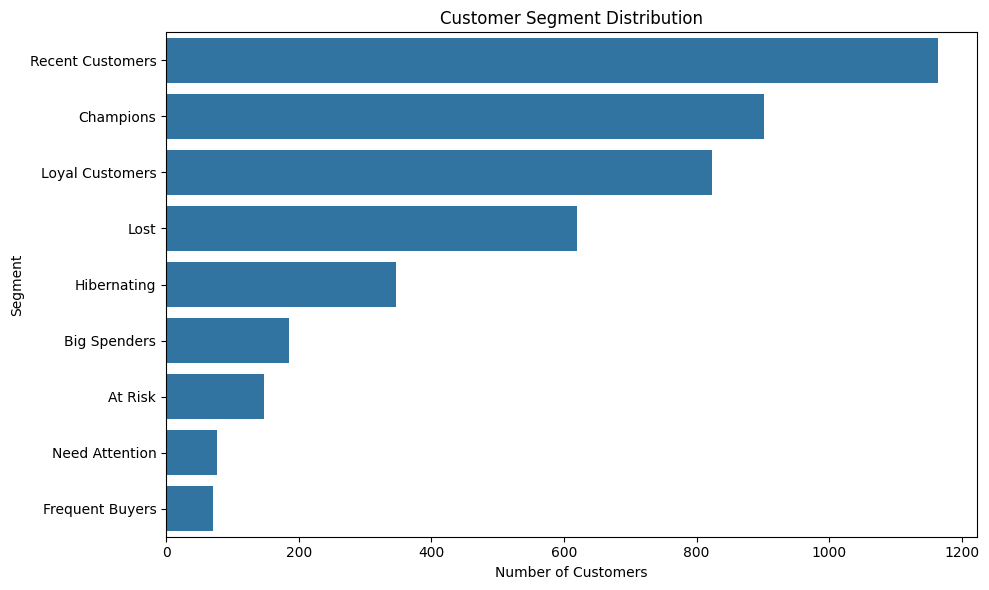

In [ ]:
# Step D: Visualizations
# 1. Segment distribution
plt.figure(figsize=(10,6))
sns.countplot(data=rfm, y='Segment', order=rfm['Segment'].value_counts().index)
plt.title('Customer Segment Distribution')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')
plt.tight_layout()
plt.show()

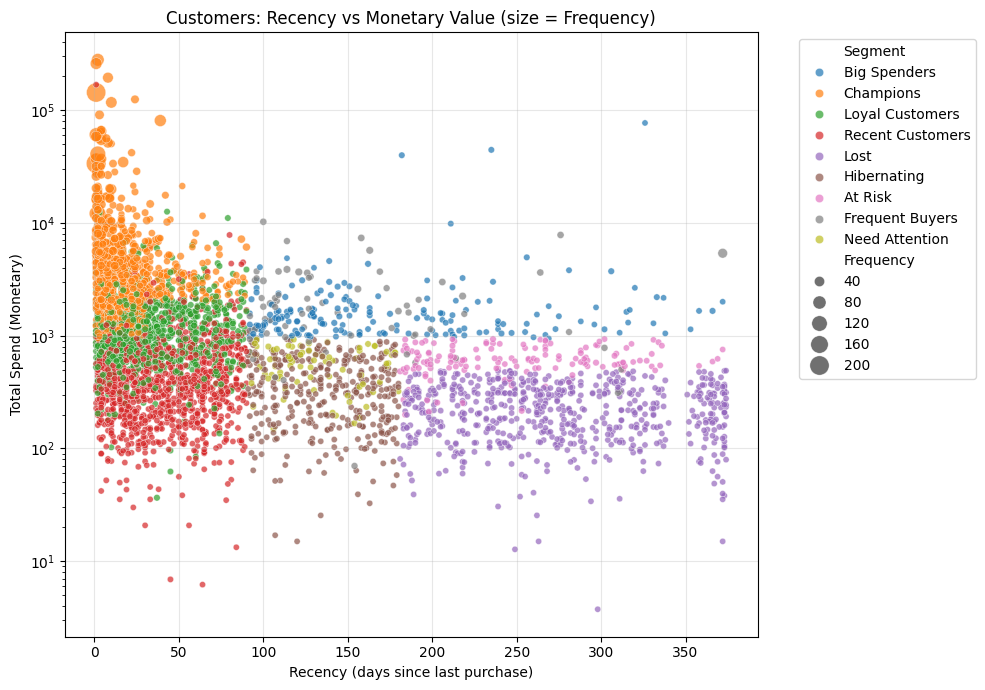

In [ ]:
# Scatter plot: Recency vs Monetary, colored by Segment
plt.figure(figsize=(10,7))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', size='Frequency',
                sizes=(20, 200), alpha=0.7, palette='tab10')
plt.title('Customers: Recency vs Monetary Value (size = Frequency)')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Total Spend (Monetary)')
plt.yscale('log')  # better view for skewed monetary
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Save the RFM table for later use
rfm.to_csv("/content/drive/MyDrive/Custora-RFM-Based Customer Segmentation & Retention Analysis/rfm_segments.csv", index=False)
print("\nRFM table saved as rfm_segments.csv")

print("\nPhase 3 completed ✓ You now have RFM scores and customer segments!")


RFM table saved as rfm_segments.csv

Phase 3 completed ✓ You now have RFM scores and customer segments!


In [ ]:
# Segment counts & percentages
segment_summary = rfm['Segment'].value_counts().to_frame(name='Count')
segment_summary['Percentage'] = (segment_summary['Count'] / len(rfm) * 100).round(1)
segment_summary = segment_summary.sort_values('Count', ascending=False)
print("Segment Summary:")
print(segment_summary)

# Average RFM per segment (very useful for interpretation)
print("\nAverage RFM per Segment:")
print(rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(1).sort_values('Monetary', ascending=False))

Segment Summary:
                  Count  Percentage
Segment                            
Recent Customers   1164        26.8
Champions           901        20.8
Loyal Customers     824        19.0
Lost                620        14.3
Hibernating         347         8.0
Big Spenders        186         4.3
At Risk             148         3.4
Need Attention       77         1.8
Frequent Buyers      71         1.6

Average RFM per Segment:
                  Recency  Frequency  Monetary
Segment                                       
Champions            17.5       12.2    6677.9
Big Spenders        175.3        2.5    2533.0
Frequent Buyers     153.5        6.9    2207.2
Loyal Customers      34.6        3.9    1305.0
Recent Customers     40.9        1.4     673.6
At Risk             249.8        2.0     625.2
Need Attention      131.1        3.3     559.7
Hibernating         136.5        1.4     365.9
Lost                276.7        1.1     233.6


# Business Interpretation & Recommendations

This section explains what the RFM segments mean for the business and suggests practical actions to increase revenue and improve customer retention.

## Segment Overview

We segmented **4,338 unique customers** using Recency, Frequency, and Monetary values. Here are the key segments with actual numbers from the analysis:

| Segment            | Count | Percentage | Avg Recency (days) | Avg Frequency | Avg Monetary | Main Characteristics                              |
|--------------------|-------|------------|---------------------|---------------|--------------|---------------------------------------------------|
| Recent Customers   | 1164  | 26.8%      | 40.9                | 1.4           | $673.6       | Largest group — mostly new or one-time buyers     |
| Champions          | 901   | 20.8%      | 17.5                | 12.2          | $6,677.9     | Best customers — recent, very frequent, very high value |
| Loyal Customers    | 824   | 19.0%      | 34.6                | 3.9           | $1,305.0     | Buy regularly, good spenders                      |
| Lost               | 620   | 14.3%      | 276.7               | 1.1           | $233.6       | Long inactive, low past value — likely churned    |
| Hibernating        | 347   | 8.0%       | 136.5               | 1.4           | $365.9       | Inactive for months, low engagement               |
| Big Spenders       | 186   | 4.3%       | 175.3               | 2.5           | $2,533.0     | High spenders but not recent                      |
| At Risk            | 148   | 3.4%       | 249.8               | 2.0           | $625.2       | Previously good, now slipping away                |
| Need Attention     | 77    | 1.8%       | 131.1               | 3.3           | $559.7       | Average frequency and spend, needs nudge          |
| Frequent Buyers    | 71    | 1.6%       | 153.5               | 6.9           | $2,207.2     | Buy often but not recently                        |

## Key Business Insights

- **Champions (20.8%)** are only about 1 in 5 customers, but they have extremely high spend (~$6,678 on average) and buy very often → they drive a large part of total revenue.
- **Recent Customers (26.8%)** are the biggest group, but most buy only once (avg frequency 1.4) → big opportunity to turn them into repeat buyers.
- **Around 26% are at risk or lost** (Lost + At Risk + Hibernating) → these customers are inactive for a long time and represent potential lost revenue.
- **High-value but dormant groups** (Big Spenders + Frequent Buyers ≈ 6%) have already spent a lot in the past → reactivating them could bring quick wins.

## Recommended Actions by Segment

1. **Champions** (20.8%)  
   → **Goal**: Keep them happy and increase their spend  
   → **Actions**:  
     - Create a VIP program (early access to new products, free shipping, exclusive offers)  
     - Send personalized thank-you messages or small birthday gifts  
     - Invite them to give feedback or test new items

2. **Loyal Customers** (19.0%)  
   → **Goal**: Increase their average spend and referrals  
   → **Actions**:  
     - Loyalty points system (earn points per purchase, redeem for discounts)  
     - Referral program: “Refer a friend, both get 15% off”  
     - Send emails with products related to what they already buy

3. **Recent Customers** (26.8%)  
   → **Goal**: Turn one-time buyers into repeat customers  
   → **Actions**:  
     - Send a 3–5 email welcome series with product tips and recommendations  
     - Offer 10–15% off or free shipping on their second purchase within 60 days  
     - Ask for reviews with a small discount incentive

4. **Big Spenders** (4.3%)  
   → **Goal**: Bring them back quickly  
   → **Actions**:  
     - Personalized “We miss you” email with 20% off + free gift  
     - Offer special high-value bundles based on their past purchases

5. **Frequent Buyers** (1.6%)  
   → **Goal**: Restart their buying habit  
   → **Actions**:  
     - Email: “Your favorite items are back in stock” + discount  
     - Suggest subscription for items they bought often

6. **At Risk** (3.4%)  
   → **Goal**: Prevent full churn  
   → **Actions**:  
     - Win-back campaign: 25% off coupon + “We miss you” message  
     - Limited-time flash sale for products they liked before

7. **Hibernating & Lost** (22.3% combined)  
   → **Goal**: Low-cost try or accept churn  
   → **Actions**:  
     - Send one automated email with a survey + small discount  
     - For Lost: low priority — save marketing budget for better segments

8. **Need Attention** (1.8%)  
   → **Goal**: Move them to higher-value segments  
   → **Actions**:  
     - General email campaign with product recommendations + small offer

## Conclusion

This RFM analysis shows clear opportunities to grow revenue:
- Protect and reward **Champions** and **Loyal Customers** (≈40% of base)
- Convert **Recent Customers** into repeat buyers
- Reactivate **At Risk** and **Big Spenders** with targeted offers
- Reduce effort on **Lost** customers

By using these targeted strategies, the business can improve customer retention, increase average order value, and reduce churn cost-effectively.




# RFM Customer Segmentation & Retention Analysis

**Date:** February 2025  
**Goal:** Clean online retail data → explore patterns → segment customers using RFM → give business recommendations to improve retention and sales

**Dataset:** UCI Online Retail (2010–2011 transactions)